https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Fine_tuning_Wav2Vec2_for_English_ASR.ipynb#scrollTo=KuUbPW7oV-B5

- Wav2Vec2 was pretrained on the audio data of LibriSpeech and LibriVox which both were sampling with 16kHz
- https://github.com/pytorch/fairseq/blob/fcca32258c8e8bcc9f9890bf4714fa2f96b6b3e1/fairseq/models/wav2vec/wav2vec2_asr.py
- https://github.com/pytorch/fairseq/issues/2917
- https://github.com/vrindaprabhu/datasets/blob/186a657263ee07b8583cacd7f6b4a1082ae829d4/datasets/timit_asr/timit_asr.py

In [21]:
import sys
sys.path.append("../")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
%env DATASET_PATH=/shared/g-luo/vctk

env: DATASET_PATH=/shared/g-luo/vctk


In [23]:
from hyper_params import *

In [24]:
from train import load_data
train_loader, val_loader = load_data(TrainingParams(), DataParams())

INFO: Loading Audio Lengths
Number of samples:  37372


In [25]:
from models.tacotron2 import Tacotron2, Tacotron2Loss
from models.wav2vec_asr import Wav2VecASR, Wav2VecASRLoss
from models.wav2vec_id import Wav2VecID, Wav2VecIDLoss
from multitask import Task, AccentedMultiTaskNetwork

In [26]:
tasks = []

In [27]:
from metrics import WERAccuracy
acc = WERAccuracy()

In [28]:
lr, weight_decay = 1e-5, 0

model = Wav2VecASR(Wav2VecASRParams())
loss = Wav2VecASRLoss()
tasks.append(Task(model, loss, lr, weight_decay, 1, 'asr', [acc]))

In [29]:
# model = Wav2VecID(Wav2VecIDParams())
# loss = Wav2VecIDLoss()
# tasks.append(Task(model=model, loss=loss, learning_rate=lr, weight_decay=weight_decay, name='id', loss_weight=1))

In [30]:
# model = Tacotron2(TacotronParams())
# loss = Tacotron2Loss()
# tasks.append(Task(model, loss, lr, weight_decay, 'tts'))

In [31]:
multitask_params = MultiTaskParams(hidden_dim=[13])
multitask = AccentedMultiTaskNetwork(multitask_params, tasks)

Some weights of the model checkpoint at facebook/wav2vec2-large-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [33]:
from pytorch_lightning import Trainer

trainer = Trainer(max_epochs=1, gpus=1, accelerator="gpu", devices=[7])
trainer.fit(multitask, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]

  | Name          | Type          | Params
------------------------------------------------
0 | bottleneck    | Sequential    | 13.5 K
1 | models        | ModuleList    | 33.2 K
2 | wav2vec_model | Wav2Vec2Model | 315 M 
------------------------------------------------
311 M     Trainable params
4.2 M     Non-trainable params
315 M     Total params
1,261.903 Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 11.93 GiB total capacity; 8.33 GiB already allocated; 8.69 MiB free; 8.56 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
trainer.validate(model=multitask, dataloaders=val_loader)

In [2]:
multitask = multitask.to("cuda:7")
for batch in train_loader:
    for k in batch:
        batch[k] = batch[k].to("cuda:7")
    target = batch["wav2vec_text"]
    pred = multitask(batch)["asr"]
    print(acc(pred, target))
    break

NameError: name 'multitask' is not defined

T-SNE Visualization

In [57]:
import json
num_accents = 13
named_accents = json.load(open("/shared/g-luo/vctk/VCTK-Corpus-0.92/speaker_accent.json"))
accents = dataset.accent_map
mapping = {}
for speaker in named_accents.keys():
    mapping[accents[speaker]] = named_accents[speaker]
mapping

{4: 'English',
 9: 'Scottish',
 8: 'NorthernIrish',
 6: 'Irish',
 5: 'Indian',
 12: 'Welsh',
 11: 'Unknown',
 0: 'American',
 3: 'Canadian',
 10: 'SouthAfrican',
 1: 'Australian',
 7: 'NewZealand',
 2: 'British'}

In [58]:
from data_utils import *
from torch.utils.data import DataLoader
batch_size = 16
dataset = VCTK(DataParams(), precompute_features=True)
collate_fn = Collate()
loader = DataLoader(dataset, shuffle=True, batch_size=batch_size, drop_last=True, collate_fn=collate_fn)

In [59]:
from tqdm import tqdm
num_batches = 100
feats = []
labels = []
device = "cuda:0"
multitask = multitask.to(device)
for i, batch in tqdm(enumerate(loader)):
    if i > num_batches:
        break
    batch["wav2vec_input"] = batch["wav2vec_input"].to(device)
    feat = multitask.get_wav2vec_features(batch)
    for i in range(feat.shape[0]):
        feats.append(feat[i].cpu().detach().numpy())
        labels.append(batch["accents"][i].detach().numpy())

101it [02:03,  1.23s/it]


In [62]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

feats = np.vstack(feats)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(feats)

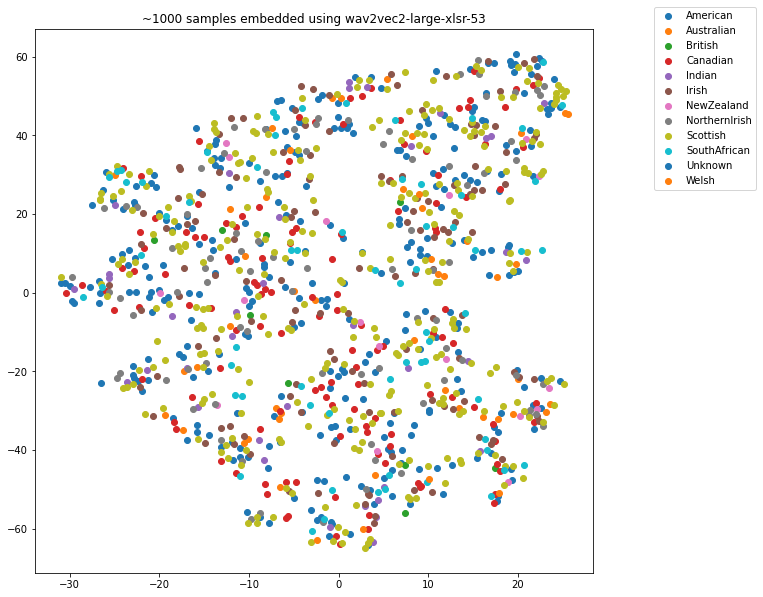

In [92]:
plt.figure(figsize=(10, 10))

for i in range(num_accents):
    idxs = [idx for idx in range(len(labels)) if labels[idx] == i]
    plt.scatter(X_embedded[idxs, 0], X_embedded[idxs, 1], label=mapping[i])
    
plt.title("~1000 samples embedded using wav2vec2-large-xlsr-53")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig('wav2vec2-large-960h.png')

In [20]:
# from pytorch_lightning import Trainer
# training_params = TrainingParams()
# trainer = Trainer(gpus=1, max_epochs=training_params.epochs, gradient_clip_val=training_params.grad_clip_thresh)
# trainer.fit(multitask, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type          | Params
------------------------------------------------
0 | bottleneck    | Sequential    | 13.3 K
1 | models        | ModuleList    | 182   
2 | wav2vec_model | Wav2Vec2Model | 315 M 
------------------------------------------------
13.5 K    Trainable params
315 M     Non-trainable params
315 M     Total params
1,261.770 Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')
tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')
tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')
tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')
tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9], device='cuda:0')


Scratchbook Cont

In [ ]:
%%capture output
device="cuda"
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

model_name = "facebook/wav2vec2-base"
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)

In [ ]:
from data_utils import VCTK

data_collator = DataCollator(processor=processor)
vctk = VCTK("/shared/g-luo/vctk")
vctk = vctk.map(lambda batch: preprocess(batch, processor))

In [ ]:
# from transformers import TrainingArguments

# training_args = TrainingArguments(
#   output_dir="./runs",
#   group_by_length=True,
#   per_device_train_batch_size=32,
#   evaluation_strategy="steps",
#   num_train_epochs=30,
#   fp16=True,
#   gradient_checkpointing=True,
#   save_steps=500,
#   eval_steps=500,
#   logging_steps=500,
#   learning_rate=1e-4,
#   weight_decay=0.005,
#   warmup_steps=1000,
#   save_total_limit=2,
#   push_to_hub=False,
# )

In [ ]:
# from transformers import Trainer
# from torch.utils.data import Subset

# trainer = Trainer(
#     model=model,
#     data_collator=data_collator,
#     args=training_args,
#     compute_metrics=lambda pred: compute_metrics(pred, processor, wer_metric),
#     train_dataset=train_dataset,
#     eval_dataset=train_dataset,
#     tokenizer=processor.feature_extractor,
# )

Scratchbook

In [ ]:
from data_utils import VCTK

DATASET_PATH="/shared/g-luo/vctk"
vctk = VCTK(path=DATASET_PATH, sample_rate=16000)

audio = vctk.__getitem__(0)["waveform"]
rate = 16000
input_values = processor(audio[0], sampling_rate = rate, return_tensors = 'pt').input_values
input_values = input_values.to(device)

In [ ]:
import torch
logits = model(input_values).logits
predicted_ids = torch.argmax(logits, dim =-1)
transcriptions = tokenizer.decode(predicted_ids[0])
print(transcriptions)
print(vctk.__getitem__(0)["text"])

In [ ]:
# import IPython.display as ipd
# import numpy as np
# import random

# ipd.Audio(data=np.asarray(), autoplay=True, rate=16000)

In [ ]:
import torch
batch = 2, 
dummy = torch.ones()